### Stworzenie modelu sieci GAN

In [12]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.optimizers import Adam
from keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from keras.utils.vis_utils import plot_model

In [13]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
    
data=unpickle('cifar-10-batches-py/data_batch_1')

def convert_to_rgb(image):
    image_rgb=np.zeros((32,32,3))
    image_rgb[:,:,0]=np.reshape(image[0:1024],(32,32))
    image_rgb[:,:,1]=np.reshape(image[1024:2048],(32,32))
    image_rgb[:,:,2]=np.reshape(image[2048:3072],(32,32))
    image_rgb = (image_rgb- 127.5) / 127.5
    
    return np.array(image_rgb,dtype='float')

def get_one_class(dict,classNum):
    response=[]
    for label,data in zip(dict[b'labels'],dict[b'data']):
            if label==classNum:
                response.append(convert_to_rgb(data))
    return np.array(response)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


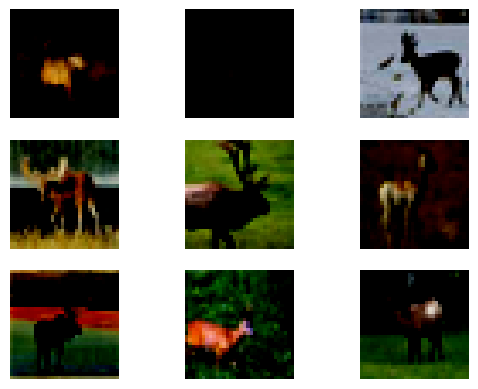

In [14]:
# Wybrana klasa deer
data=get_one_class(data,4)

plt.figure(1)
for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.axis('off')
    plt.imshow(data[i])
plt.show()


 Model dyskryminacyjny

In [22]:
class Discriminator():
    def __init__(self,imageShape):
        self.model=models.Sequential()
        self.model.add(layers.Conv2D(filters=64,kernel_size=(3, 3), strides=(2,2), padding='same',input_shape=imageShape))
        self.model.add(layers.LeakyReLU(alpha=0.2))        
        self.model.add(layers.Conv2D(filters=128, kernel_size=(3,3), strides=(2, 2), padding='same', input_shape=imageShape))
        self.model.add(layers.LeakyReLU(alpha=0.3))       
        self.model.add(layers.Conv2D(filters=256, kernel_size=(3,3), strides=(2, 2), padding='same', input_shape=imageShape))
        self.model.add(layers.LeakyReLU(alpha=0.1))
        self.model.add(layers.Flatten(name='Discriminator-Flatten-Layer')) # Flatten the shape
        self.model.add(layers.Dropout(0.4)) # Randomly drop some connections for better generalization
        self.model.add(layers.Dense(1, activation='sigmoid')) # Output Layer
        self.model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

Model generatywny

In [23]:
class Generator(): 
    def __init__(self,latent_dim):
        channels=3
        self.model = models.Sequential()
        n_nodes = 16 * 16 * 128
        self.model.add(layers.Dense(n_nodes, input_dim=latent_dim))
        self.model.add(layers.LeakyReLU(alpha=0.1))
        self.model.add(layers.Reshape((16, 16, 128)))                           
        self.model.add(layers.Conv2DTranspose(filters=256, kernel_size=(4,4), strides=(2,2), padding='same'))
        self.model.add(layers.LeakyReLU())    
        self.model.add(layers.Conv2D(256, 5, padding='same'))
        self.model.add(layers.LeakyReLU())
        self.model.add(layers.Conv2D(channels, 7, activation='tanh', padding='same'))

Model sieci GAN

In [24]:
class Gan():
    
    disc_loss=list()
    gen_loss=list()
    disc_fake_accuracy=list()
    disc_real_accuracy=list()

    
    def __init__(self,discriminator,generator,real_samples):     
        self.discriminator=discriminator
        self.real_samples=real_samples
        self.generator=generator
        self.discriminator.trainable = False
        self.model = Sequential(name="DCGAN") # GAN Model
        self.model.add(generator) 
        self.model.add(discriminator) 
        self.model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

    def performance_summary(self,latent_dim,epochs ,n=50,plot=False):
        scaler=MinMaxScaler(feature_range=(-1, 1))
        data=self.real_samples.reshape(-1, 1)
        scaler.fit(data)
        x_real, y_real = self.random_real_sample(n , self.real_samples)
        _, real_accuracy = self.discriminator.evaluate(x_real, y_real, verbose=0)
        x_fake, y_fake = self.fake_samples(latent_dim, n)
        # Evaluate the descriminator on fake (generated) data
        _, fake_accuracy = self.discriminator.evaluate(x_fake, y_fake, verbose=0)
        self.disc_real_accuracy.append(real_accuracy)
        self.disc_fake_accuracy.append(fake_accuracy)
        print(f"*** Evaluation for epoch {epochs} ***")
        print("Discriminator Accuracy on REAL images: ", real_accuracy)
        print("Discriminator Accuracy on FAKE (generated) images: ", fake_accuracy)
        

        x_fake_inv_trans=x_fake.reshape(-1, 1)
        x_fake_inv_trans=scaler.inverse_transform(x_fake_inv_trans)
        x_fake_inv_trans=x_fake_inv_trans.reshape(n, 32, 32, 3)
        
        if plot:
            fig, axs = plt.subplots(3, 3, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
            fig.suptitle(f'Images after {epochs} epochs')
            k=0
            for i in range(0,3):
                for j in range(0,3):
                    axs[i,j].matshow(x_fake_inv_trans[k])
                    axs[i,j].axis('off')
                    k=k+1
            plt.savefig(f'epoch_{epochs}_images.png', bbox_inches='tight')
            plt.figure(2)
            plt.plot(self.disc_loss)
            plt.plot(self.gen_loss)
            plt.legend(['Discriminator loss','Generator loss'])
            plt.savefig(f'epoch_{epochs}_loss.png', bbox_inches='tight')

    def random_real_sample(self,n, dataset):  
        X = dataset[np.random.choice(self.real_samples.shape[0], n, replace=True), :]
        y = np.ones((n, 1))
        return X, y
    
    def fake_samples(self, latent_dim, n):
        latent_output = self.latent_vector(latent_dim, n)
        X = self.generator.predict(latent_output)
        y = np.zeros((n, 1))
        return X, y    
    
    def latent_vector(self,latent_dim, n):      
        latent_input = np.random.randn(latent_dim * n)
        latent_input = latent_input.reshape(n, latent_dim)
        return latent_input



    def train(self,dataset,latent_dim,n_epochs,n_batch,n_eval):
         half_batch = int(n_batch / 2)
         for i in range(n_epochs):
            
        # Discriminator training
            x_real, y_real = self.random_real_sample(half_batch, dataset)
            x_fake, y_fake = self.fake_samples(latent_dim, half_batch)
            X, y = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
            discriminator_loss, _ = self.discriminator.train_on_batch(X, y)
        
        # Generator training
            x_gan = self.latent_vector(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            generator_loss = self.model.train_on_batch(x_gan, y_gan)
            self.disc_loss.append(discriminator_loss)
            self.gen_loss.append(generator_loss)
            if (i) % n_eval == 0:
                print("Epoch number: ", i)
                print("*** Training ***")
                print("Discriminator Loss ", discriminator_loss)
                print("Generator Loss: ", generator_loss)
                self.performance_summary(latent_dim,i,half_batch,True)
            elif (i) % int(50) == 0:
                print("Epoch number: ", i)
                print("*** Training ***")
                print("Discriminator Loss ", discriminator_loss)
                print("Generator Loss: ", generator_loss)
                self.performance_summary(latent_dim,i,half_batch,False)

In [21]:
if __name__ == "__main__":
    latent_dim = 40
    height = 32
    width = 32
    channels = 3
    n_epochs=6001
    n_batch=32
    n_eval=1000
    
    gen = Generator(latent_dim)
    dis = Discriminator((height,width ,channels))
    gan=Gan(dis.model,gen.model,data)
    gan.train(data,latent_dim,n_epochs,n_batch,n_eval)

1/1 [==============================] - 1s 551ms/step
Epoch number:  0
*** Training ***
Discriminator Loss  0.6890521049499512
Generator Loss:  0.6924110054969788


ValueError: in user code:

    File "c:\Users\pawel\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1852, in test_function  *
        return step_function(self, iterator)
    File "c:\Users\pawel\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1836, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\pawel\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1824, in run_step  **
        outputs = model.test_step(data)
    File "c:\Users\pawel\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1788, in test_step
        y_pred = self(x, training=False)
    File "c:\Users\pawel\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\pawel\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_3' (type Sequential).
    
    Input 0 of layer "conv2d_7" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 1)
    
    Call arguments received by layer 'sequential_3' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 1), dtype=float32)
      • training=False
      • mask=None
